In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize 
from scipy.optimize import curve_fit
import pandas as pd
import math

In [5]:
# %%
#Defining all functions that will be used in program
def csv_to_np(filename):
    #filemane is a csv of xrd data with the first column being two-theta 
    # and subsequent columns being xray intensities
    data = pd.read_csv(filename)
    return(np.array(data))

def norm(x):
    #returns normalized version of an array
    return x/np.nanmax(x)

def two_to_q(two_theta, wave):
    #two_theta is a 1D array of two_theta angles
    #wave is the X-ray energy in angstroms
    rad_theta = two_theta/2*np.pi/180
    q = 4*np.pi*np.sin(rad_theta)/wave
    return q

def find_nearest(array, value):
    #array is a 1D vector of two_theta or q values
    #value is the specific angle or q for which you want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #limit1 and limit2 are what you'd like to trime your data to 
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2,:]

def back_subtract(x, data, length):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #length is the number of values on the edges of the data you want to use to create a linear background 
    x_linear = np.hstack((x[0:length], x[-length:-1])) #I'm taking the starting and ending values
    data_linear = np.hstack((data[0:length], data[-length:-1])) #We'll use these to fit a straight line
    slope, intercept = np.polyfit(x_linear, data_linear, 1) #Do linear fit
    back = slope*x+intercept 
    data_correct=(data-back)
    return data_correct

def gaussian(x, a, b, c): 
    #generic gaussian curve, for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a*np.exp(-(x - b)**2/(2*c**2))

def normal_gaussian(x, a, b): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the peak position and 
    #b is the FWHM
    return 2/b*sqrt(ln(2)/math.pi)*np.exp(-4*ln(2)/b**2*(x - a)**2)

def two_gaussians(x, a1, b1, c1, a2, b2, c2):
        return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2))

def multi_gaussian(x, guesses):
    #NOTE This function does not work with curve fitting yet TBD
    # x is 1D array of 2-theta or q values for our fitting
    # trips is an array of fits i.e. [[200, 1, .01], [150, 1.05. .02]]
    peaks = [gaussian(x, fit[0], fit[1], fit[2]) for fit in guesses]
    return np.sum(peaks, axis=0)

# Define three peak fitting
def three_gaussians(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2)+ #this would be your initial peak center in Q
            gaussian(x, a3, b3, c3))
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)
    
def mult_pvoigt(x, e, a, b, c, a2, b2, c2, a3, b3, c3):
    return pvoigt(x, e, a, b, c) + pvoigt(x, e, a2, b2, c2) +  pvoigt(x, e, a3, b3, c3) 

def q_to_a(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    a = 2*math.pi*math.sqrt(plane[0]**2+plane[1]**2+plane[2]**2)/center
    return a

def num_files(data):
    #data is the file you are currently analyzing
    #returns columns of data (i.e. frames for XRD data from SSRL)
    size = data.shape
    return size[1]

def q_to_chem(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    #takes peak position in q and converts it to bromine percentage
    #using linear fit for bromine fraction on lattice spacing
    slope = -0.3637
    intercept = 6.2841
    br_frac = 1/slope*(q_to_a(center,plane)-intercept)
    return br_frac

def frames_to_time(x,speed,start_lag):
    #x=num_frames
    #speed=shutter speed in s
    #start_lag=t at x=0
    seconds=np.array([(x*speed)+ start_lag])
    return seconds

def perovtopbi2(q, intensity):
    #array is a 1D vector of  q values
    #intensity is a 1D vector of perovskite intensities
    leadiodide_q = 0.9 #rough q of lead iodide peak 
    pad = 10 #number of points around leadiodide_q to look for true max
    peak = find_nearest(q,leadiodide_q)
    leadiodide_inensity = max(intensity[peak-pad:peak+pad])
    ratio = max(intensity)/leadiodide_inensity
    return ratio

In [6]:
# %% Create dictionary for storing analyzed results - to be run at the start of a new session
samplelist = []
results = {"Sample":"Results"}

In [7]:
#%% Import Data
samplename = 'B1_60min_light'#'B1_MaPbI2Br_Light60min'
perov_import = csv_to_np('/Users/grace/Desktop/wellesley solar/' + samplename + '.csv')
light_on = 1 # if light on set to 1 else set to 0
interval = 2 # time interval between frames in minutes


In [8]:
# Covert to Q
q = two_to_q(perov_import[:,0],0.982381)
perov = perov_import[:,1:] #seperate XRD intensities from rest of data 


In [9]:
# Trim and Remove Background
miller = [2, 0, 0] #peak you are trying to capture
q_1 = 1.92 #lower limit in q
q_2 = 2.18 # upper limit in q 
q_sub, perov_sub = trim_data(q,perov,q_1,q_2)
perov_fit = perov_sub
files = num_files(perov_sub)
for file in range(files): 
    perov_fit[:,file] = back_subtract(q_sub,perov_sub[:,file],10) #remove background from that file

In [10]:
# Initialize parameters of interest
files = num_files(perov)
time = np.arange(0, files*interval, interval) + interval/2 #time interval of the experiment
print(files)

30


0.009625759837883248
2.03289846372718


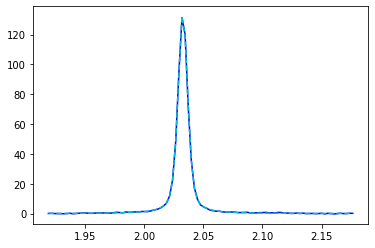

In [11]:
#  Do Curve Fitting of Initial Frame (assumes if light is on, new composition)
if light_on:
    image = 0 #index of file you want to look at
p0 = [0.2, 300, 2, .01] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
upper_limit = [1, 3000, q_2, 5]
lower_limit = [0, 0, q_1, 0]
popt,pcov = curve_fit(pvoigt, q_sub, perov_fit[:,image], p0, bounds=(lower_limit, upper_limit), maxfev=6000)
plt.plot(q_sub,perov_fit[:,image],'b-', label='Data') #plot subfield of data
plt.plot(q_sub,pvoigt(q_sub, *popt),'c--', label='Model') #plot best fit
init_q = popt[2] #this is the inital peak position that will be used as a reference
FWHM = popt[3]
print(FWHM)
print(init_q)

In [38]:
perov_diff=perov_fit[:,-1]-(perov_fit[:,0])
#need to normalize intensity
#need to generalize for all frames

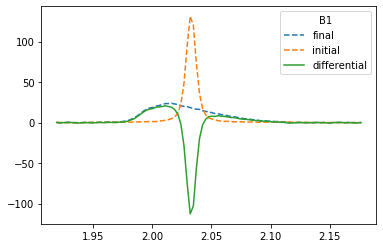

In [40]:
plt.plot(q_sub,perov_fit[:,-1],'--' ,label='final')
plt.plot(q_sub,perov_fit[:,0],'--' ,label='initial')
plt.plot(q_sub,perov_diff, label='differential')
plt.legend(title='B1')

In [14]:
# %% Dynamics of Process
#  Plot Integrated Intensity over time
totalintensity = np.zeros(files)
for frame in range(files):
    totalintensity[frame] = sum(perov_fit[:,frame])

Text(0, 0.5, 'Integrated Intensity [Normalized]')

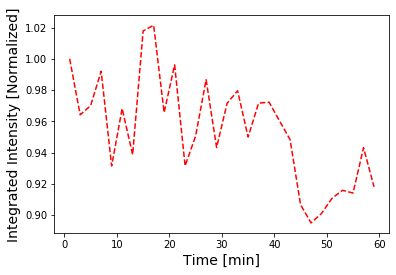

In [15]:
plt.plot(time, totalintensity/totalintensity[0], 'r--')
plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Integrated Intensity [Normalized]',size=14)#Define y-axis label

In [16]:
# Plot Binned Intenisty
iod_bin = np.zeros(files)
orig_bin = np.zeros(files)
brom_bin = np.zeros(files)

In [17]:
iod_lim = find_nearest(q_sub, init_q-FWHM)#-FWHM_i)
brom_lim = find_nearest(q_sub, init_q+FWHM)#+FWHM_b)

In [18]:
for frame in range(files):
    iod_bin[frame] = sum(perov_fit[:iod_lim,frame])
    orig_bin[frame] = sum(perov_fit[iod_lim:brom_lim,frame])
    brom_bin[frame] = sum(perov_fit[brom_lim:,frame])

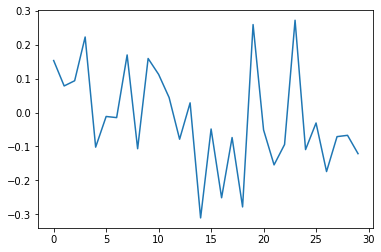

In [19]:
plt.plot(perov_fit[1])

In [20]:
iod_diff = np.zeros(files)
orig_diff = np.zeros(files)
brom_diff = np.zeros(files)
for frame in range(files):
    iod_diff[frame] = sum(perov_diff[:iod_lim,frame])
    orig_diff[frame] = sum(perov_diff[iod_lim:brom_lim,frame])
    brom_diff[frame] = sum(perov_diff[brom_lim:,frame])

Text(0.5, 1.0, 'B1 Differential Intensity Dynamics')

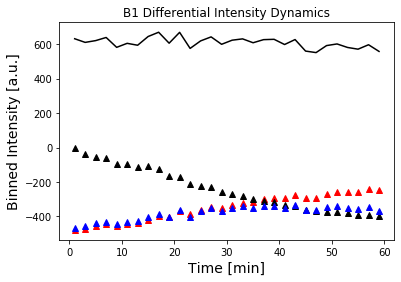

In [21]:
plt.plot(time, iod_diff-orig_diff[0], 'r^')
plt.plot(time, orig_diff-orig_diff[0], 'k^')
plt.plot(time, brom_diff-orig_diff[0], 'b^')
plt.plot(time, brom_diff+iod_diff+orig_diff, 'k-')


plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Binned Intensity [a.u.]',size=14)#Define y-axis label
plt.title('B1 Differential Intensity Dynamics')

Text(0.5, 1.0, 'B1 Binned Intensity Dynamics')

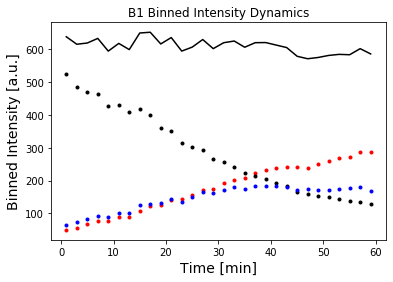

In [22]:
plt.plot(time, iod_bin, 'r.')
plt.plot(time, orig_bin, 'k.')
plt.plot(time, brom_bin, 'b.')
plt.plot(time, brom_bin+iod_bin+orig_bin, 'k-')


plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Binned Intensity [a.u.]',size=14)#Define y-axis label
plt.title('B1 Binned Intensity Dynamics')

In [23]:
# %% Save Variables
samplelist.append(samplename) #creates a list of the samples you've looked at this session
datatostore = [time, totalintensity, iod_bin, orig_bin, brom_bin] #creates a list of relevant data
results[samplename] = datatostore #adds an item to a dictionary where the sample name is linked to these results
print(samplelist)

['B1_60min_light']


In [24]:
##ionic transport (light on)
def ionfuncneg(x, a, t, b):
    # a is at time = 0 value
    # t rate constant
    # b is steady state value time = inf
    return a*np.exp(-x/t)+b
def ionfuncpos(x, a, t, b):
    # a is at time = 0 value
    # t rate constant
    # b is steady state value time = inf
    return a*np.exp(x/t)+b

In [25]:
#ion transport orig bin
p0 = [100,10^3,100]


popt, pcov = curve_fit(ionfuncneg, time, orig_bin, p0, maxfev=8000)
orig_ion = ionfuncneg(time, *popt)
#orig_ion=np.array([ionfunc(time, *popt)])
print(orig_ion) ##should be array w/ shape (30,) but prints only single value
print ('a:', popt[0])
print('t:', popt[1])
print('b:',popt[2])

[525.88883042 503.86418804 482.57233858 461.98890092 442.09030514
 422.85376552 404.25725445 386.27947723 368.89984765 352.09846444
 335.85608848 320.15412075 304.97458107 290.30008746 276.11383629
 262.39958299 249.14162349 236.32477622 223.93436469 211.95620076
 200.37656833 189.18220766 178.36030017 167.89845379 157.78468875
 148.00742386 138.55546326 129.41798357 120.58452155 112.04496208]
a: 673.2621577110538
t: 59.10586470755714
b: -136.07836099660415


In [26]:
#ion transport iodine bin
p0 = [100,-100,-100]

popt, pcov = curve_fit(ionfuncpos, time, iod_bin, p0)

iod_ion=ionfuncpos(time, *popt)
print(iod_ion) ##should be array w/ shape (30,) but prints only single value
print ('a:', popt[0])
print('t:', popt[1])
print('b:',popt[2])

[ 39.87966972  50.98281471  61.88116606  72.57850112  83.07852755
  93.38488466 103.5011446  113.43081364 123.17733341 132.744082
 142.13437526 151.35146782 160.39855432 169.27877047 177.99519411
 186.55084637 194.94869259 203.19164347 211.28255599 219.22423444
 227.0194314  234.67084867 242.18113822 249.55290308 256.78869832
 263.89103183 270.86236527 277.70511489 284.42165238 291.01430568]
a: -607.6005463897701
t: -107.4294137430865
b: 641.8506462041969


In [27]:
#ion transport bromine bin
p0 = [100,-10^3,-10]

popt, pcov = curve_fit(ionfuncpos, time, brom_bin, p0)

brom_ion=ionfuncpos(time, *popt)
print("Brom_Ion:")
print(brom_ion) ##should be array w/ shape (30,) but prints only single value
print ('a:', popt[0])
print('t:', popt[1])
print('b:',popt[2])

Brom_Ion:
[ 55.06217901  68.40517994  80.42771694  91.26046714 101.02117546
 109.81593441 117.74033729 124.88051718 131.31408316 137.1109639
 142.3341677  147.04046738 151.28101734 155.10190958 158.54467472
 161.64673335 164.44180284 166.96026375 169.22949012 171.27414694
 173.11645832 174.77644896 176.27216188 177.61985451 178.83417537
 179.92832336 180.91419113 181.80249443 182.60288854 183.32407321]
a: -142.03951749539004
t: -19.192200216806256
b: 189.89030289795403


Text(0.5, 1.0, 'B1 Binned Intensity Dynamics')

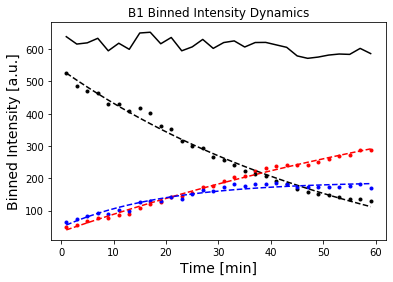

In [28]:
plt.plot(time, iod_bin, 'r.')
plt.plot(time, orig_bin, 'k.')
plt.plot(time, brom_bin, 'b.')
plt.plot(time, brom_bin+iod_bin+orig_bin, 'k-')
plt.plot(time, orig_ion, 'k--')
plt.plot(time, iod_ion, 'r--')
plt.plot(time, brom_ion, 'b--')

plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Binned Intensity [a.u.]',size=14)#Define y-axis label
plt.title('B1 Binned Intensity Dynamics')